> **tomato juice dataset**
<br>` 'quality' is the target feature for classification `
<br>` the other features are chemical properties of our product `

**Import the main libraries**

In [1]:
import numpy as np
import pandas as pd

from time import time

_import the local library_

In [2]:
# add parent folder path where lib folder is
import sys
if ".." not in sys.path:import sys; sys.path.insert(0, '..') 

In [3]:
from mylib import show_labels_dist, show_metrics, bias_var_metrics

**Import the Dataset**

In [4]:
## file path: unix style
df = pd.read_csv('../datasets/tomatjus.csv')

# shape method gives the dimensions of the dataset
print('Dataset dimensions: {} rows, {} columns'.format(df.shape[0], df.shape[1]))

Dataset dimensions: 1599 rows, 12 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  pulp                  1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


***
**Data Preparation and EDA** (unique to this dataset)
* _Check for missing values_
* _Quick visual check of unique values_
* _Split the classification feature out of the dataset_
* _Check column names of categorical attributes ( for get_dummies() )_
* _Check column names of numeric attributes ( for Scaling )_

**_Let's skip the checking_**

**<br>Classification target feature**
<br>_Make it a multi-class problem, using text labels_

In [6]:
##  divide into classes by giving a range for quality
##  Make it a multi-class problem: {3,4,5} {6} {7.8}
bins = (2, 5, 6, 8)
group_names = ['Average', 'Premium', 'Special']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

* Split the classification feature out of the dataset 

In [7]:
## Feature being predicted ("the Right Answer")
labels_col = 'quality'
y = df[labels_col]

## Features used for prediction 
# pandas has a lot of rules about returning a 'view' vs. a copy from slice
# so we force it to create a new dataframe 
X = df.copy()
X.drop(labels_col, axis=1, inplace=True)

***
**<br>Create Test // Train Datasets**
> Split X and y datasets into Train and Test subsets,<br>keeping relative proportions of each class (stratify)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=50, 
                                                    stratify=y)
# train_test_split does random selection, 
#      so we should reset the dataframe indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

**<br>Scaling** comes _after_ test // train split

In [9]:
numeri = X.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'pulp']


In [10]:
# scaling the Numeric columns 
# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))

**<br>Classifier Selection**

 **_Hyperparameter tuning is specific to each classifier_**

In [11]:
# Classifier Selection - for these examples
models = []
from sklearn.neighbors import KNeighborsClassifier 
models.append(("K-NNeighbors", KNeighborsClassifier())) 
print(models[0][0])
print(models[0][1])

K-NNeighbors
KNeighborsClassifier()


**<br>Target Label Distributions** (standard block)

In [12]:
# from our local library
show_labels_dist(X_train,X_test,y_train,y_test)

features_train: 1279 rows, 11 columns
features_test:  320 rows, 11 columns

labels_train: 1279 rows, 1 column
labels_test:  320 rows, 1 column

Frequency and Distribution of labels
         quality  %_train  quality  %_test
quality                                   
Average      595    46.52      149   46.56
Premium      510    39.87      128   40.00
Special      174    13.60       43   13.44


**<br>Fit and Predict** (standard block)

In [13]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: K-NNeighbors
Run Time 0.04 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           105            42             2
train:Premium            37            74            17
train:Special             7            17            19

~~~~
     Average :  FPR = 0.257   FNR = 0.295
     Premium :  FPR = 0.307   FNR = 0.422
     Special :  FPR = 0.069   FNR = 0.558

   macro avg :  FPR = 0.211   FNR = 0.425
weighted avg :  FPR = 0.191   FNR = 0.381

~~~~
              precision    recall  f1-score   support

     Average      0.705     0.705     0.705       149
     Premium      0.556     0.578     0.567       128
     Special      0.500     0.442     0.469        43

    accuracy                          0.619       320
   macro avg      0.587     0.5

**Bias - Variance Decomposition** (standard block)

In [14]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: K-NNeighbors
   Average bias: 0.369
   Average variance: 0.213
   Average expected loss: 0.416  "Goodness": 0.584



***

***
**Hyperparameter Tuning**
General pattern:<br>
_baseline model_<br>
>    1. Classifier selection<br> 
   2. Fit and Predict<br>
   3. Bias-Variance Tradeoff<br>
    
_optimised model_<br>
>    4. Select strategy and hyperparameters<br>
   5. Plug in the best parameter values<br>
   6. Fit and Predict<br>
   7. Bias-Variance Tradeoff

***
***

**<br>Imports** for parameter testing

In [15]:
# Default scorer for classification is sklearn.metrics.accuracy_score 
# For imbalanced classification, the accuracy score is often uninformative
# For the list of options see
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# average for each label weighted by support 
#        (number of true instances for each label)
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

eval_metric = ['wtd.avg.accuracy', 
               'balanced_accuracy', 
               'wtd.avg.f1_score', 
               'f1_weighted']

# for graphs
import matplotlib.pyplot as plt

 ***

**<br>Parameter Testing**
> * Strategy: Simple loop (no CV)
> * Strategy: Single Parameter Cross-Validation Curve
> * Strategy: Bias-Variance Decomposition 
> * Strategy: Parameter grid search

 ***

**<br>Strategy: simple loop (no CV)**

In [16]:
# ---- Specific to each classifier! ---- #
clf = models[0][1]

# hyperparameter values to test: one constant, one set
cname = 'n_neighbors'
cval = 5

paramname = 'weights'
paramrange = ['uniform', 'distance']
# ----    ---- #

for param in paramrange:
    print(models[0][0],':',cname,'=',cval,' ',paramname,'=',param)

# use a dict to set multiple parameters
    pdict = {cname:cval, paramname:param}
    clfp = clf.set_params(**pdict)

# fit and predict with the new values
    clfp.fit(X_train,y_train)
    pred = clfp.predict(X_test)
    lbls = clfp.classes_

    waa = balanced_accuracy_score(y_test, pred)
    print('Weighted Average Accuracy:  %.3f' % waa)
    
    waf = f1_score(y_test, pred, average='weighted')
    print('Weighted Average f1_score:  %.3f' % waf)

    print()

K-NNeighbors : n_neighbors = 5   weights = uniform
Weighted Average Accuracy:  0.575
Weighted Average f1_score:  0.618

K-NNeighbors : n_neighbors = 5   weights = distance
Weighted Average Accuracy:  0.669
Weighted Average f1_score:  0.693



*<br>5. Plug in the best parameter values* [manual editing]

In [18]:
## -- put best parameters into the model --##
## be sure to use a valid value from the result above !!
param = 'distance'
# ----    ---- #

# use a dict to set multiple parameters
best_vals = {cname:cval, paramname:param}
models[0][1].set_params(**best_vals)

print(models[0][0],': Best Values ')
print(models[0][1])

K-NNeighbors : Best Values 
KNeighborsClassifier(weights='distance')


In [19]:
## Copy & Paste blocks:
# 6. Fit and Predict (standard block)
# 7. Bias-Variance Tradeoff (standard block)

In [21]:
# evaluate each model in turn
clf = models[0][1];

results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: K-NNeighbors
Run Time 0.02 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           111            35             3
train:Premium            25            84            19
train:Special             3            14            26

~~~~
     Average :  FPR = 0.164   FNR = 0.255
     Premium :  FPR = 0.255   FNR = 0.344
     Special :  FPR = 0.079   FNR = 0.395

   macro avg :  FPR = 0.166   FNR = 0.331
weighted avg :  FPR = 0.155   FNR = 0.309

~~~~
              precision    recall  f1-score   support

     Average      0.799     0.745     0.771       149
     Premium      0.632     0.656     0.644       128
     Special      0.542     0.605     0.571        43

    accuracy                          0.691       320
   macro avg      0.657     0.6

In [22]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: K-NNeighbors
   Average bias: 0.287
   Average variance: 0.197
   Average expected loss: 0.372  "Goodness": 0.628



***
***

**<br>Strategy: Single Parameter Cross-Validation Curve**

K-NNeighbors 	(timer started)
Validation Curve for parameter [ n_neighbors ], scoring = balanced_accuracy



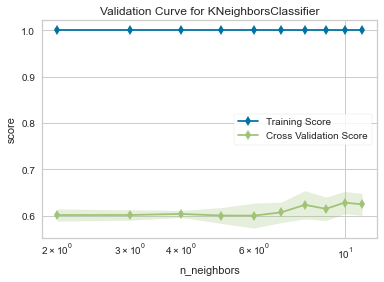

Run Time 1.69 seconds



In [24]:
from sklearn.model_selection import StratifiedKFold
# a variation of KFold that returns stratified folds,  
#   preserving the percentage of samples for each class
from yellowbrick.model_selection import ValidationCurve

# ---- Specific to each classifier! ---- #
clf = models[0][1]

## hyperparameter (can only graph one)
paramname = "n_neighbors"
# range for the hyperparameter 
#        start, stop, and step 
paramrange = np.arange(2, 12, 1)

## or, for example:
#paramname = "p"
#paramrange = [1, 2, 4]

## or, for example:
#paramname = 'weights'
#paramrange = ['uniform', 'distance']

# ----  Cross Validation  ---- #
# number of rounds
folds = 3

# choose a metric
scorer = eval_metric[1]
# ----    ---- #

# start the timer
trs = time()

print(models[0][0], '\t(timer started)')
print('Validation Curve for parameter [',paramname,'], scoring =',scorer)
print()

skf = StratifiedKFold(shuffle=True, random_state = 11, n_splits=folds)

# Create the validation curve visualizer
viz = ValidationCurve(
    clf, param_name=paramname, param_range=paramrange,
    logx=True, cv=skf, scoring=scorer, n_jobs= -1)

viz.fit(X_train, y_train)
viz.show()

tre = time() - trs
print ("Run Time {} seconds".format(round(tre,2)) + '\n')

In [22]:
## Copy & Paste blocks:
# 5. Plug in the best parameter values [manual editing]
# 6. Fit and Predict (standard block)
# 7. Bias-Variance Tradeoff (standard block)

In [25]:
#k=8
models[0][1].set_params(n_neighbors=8)
print(models[0][1])

KNeighborsClassifier(n_neighbors=8, weights='distance')


In [26]:
# evaluate each model in turn
clf = models[0][1];

results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: K-NNeighbors
Run Time 0.02 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           116            31             2
train:Premium            28            83            17
train:Special             8            13            22

~~~~
     Average :  FPR = 0.211   FNR = 0.221
     Premium :  FPR = 0.229   FNR = 0.352
     Special :  FPR = 0.069   FNR = 0.488

   macro avg :  FPR = 0.169   FNR = 0.354
weighted avg :  FPR = 0.155   FNR = 0.309

~~~~
              precision    recall  f1-score   support

     Average      0.763     0.779     0.771       149
     Premium      0.654     0.648     0.651       128
     Special      0.537     0.512     0.524        43

    accuracy                          0.691       320
   macro avg      0.651     0.6

In [25]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: K-NNeighbors
   Average bias: 0.309
   Average variance: 0.191
   Average expected loss: 0.366  "Goodness": 0.634



**<br>Strategy: Bias - Variance Decomposition**

In [28]:
from mlxtend.evaluate import bias_variance_decomp
## bias_variance_decomp() requires 
##    1. numpy ndarrays
##    2. numeric targets
from sklearn.preprocessing import LabelEncoder

# ---- Specific to each classifier! ---- #
clf = models[0][1]

# hyperparameter values to test: one constant, one set
cname = 'n_neighbors'
cval = 3

paramname = "p"
paramrange = [1, 2, 4]

# ----  Cross Validation  ---- #
# adjust num_rounds (default=200) for bootstrap cross validation
folds = 3
# ----    ---- #

# start the timer
trs = time()

## bias_variance_decomp() requires 
##    1. numpy ndarrays
##    2. numeric targets
ytrain = LabelEncoder().fit_transform(y_train)
ytest = LabelEncoder().fit_transform(y_test)

# for graphs
cn = models[0][0] + "  Parameter: " + paramname 
rx = paramrange     # the x locations for the groups

bias, var, err = [], [], []
for parm in paramrange:
    print(models[0][0],'(',cname,'=',cval,' ',paramname,'=',parm,')',end='') # no newline at the end

# use a dict to set multiple parameters
    pdict = {cname:cval, paramname:parm}
    clfp = clf.set_params(**pdict)

# fit and predict with the new values
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf, X_train.values, ytrain, X_test.values, ytest, 
        loss='0-1_loss', num_rounds=folds, random_seed=11)
    err.append(avg_expected_loss)
    bias.append(avg_bias)
    var.append(avg_var)

    msg="  Bias: %0.3f  Variance: %0.3f  E.loss: %0.3f" % (avg_bias, avg_var, avg_expected_loss)
    print(msg)

tre = time() - trs
print ("\tRun Time {} seconds".format(round(tre,2)) + '\n')

K-NNeighbors ( n_neighbors = 3   p = 1 )  Bias: 0.334  Variance: 0.140  E.loss: 0.351
K-NNeighbors ( n_neighbors = 3   p = 2 )  Bias: 0.338  Variance: 0.135  E.loss: 0.354
K-NNeighbors ( n_neighbors = 3   p = 4 )  Bias: 0.325  Variance: 0.149  E.loss: 0.360
	Run Time 0.14 seconds



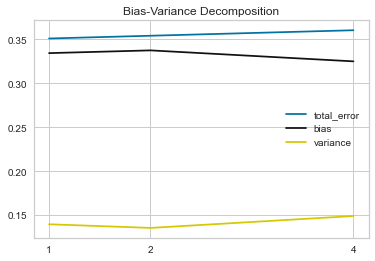

K-NNeighbors  Parameter: p


In [29]:
# line plot
fig, ax = plt.subplots()
ax.plot(rx, err, 'b', label = 'total_error')
ax.plot(rx, bias, 'k', label = 'bias')
ax.plot(rx, var, 'y', label = 'variance')
ax.legend()
ax.set_xticks(rx)
ax.set_title('Bias-Variance Decomposition')
plt.show()
print(cn)

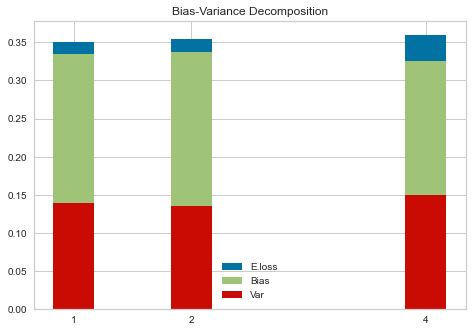

K-NNeighbors  Parameter: p


In [30]:
# stacked bar plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rx, err, color = 'b', width= 0.35)
ax.bar(rx, bias, color = 'g', width= 0.35)
ax.bar(rx, var, color = 'r', width= 0.35)
ax.legend(labels=['E.loss', 'Bias', 'Var'])
ax.set_title('Bias-Variance Decomposition')
ax.set_xticks(rx)
plt.show()
print(cn)

In [29]:
## Copy & Paste blocks:
# 5. Plug in the best parameter values [manual editing]
# 6. Fit and Predict (standard block)
# 7. Bias-Variance Tradeoff (standard block)

***
***

**<br>Strategy: Parameter grid search**

In [32]:
# Each parameter increases time exponentially!
from sklearn.model_selection import GridSearchCV

# ---- Specific to each classifier! ---- #
clf = models[0][1]

# hyperparameter: values to test (minimum 2x2 Grid)

value_grid = {'n_neighbors': [3, 4, 5, 7], 
              'p': [1, 2, 4, 5], 
              'weights': ['uniform', 'distance']}

# ----  Cross Validation  ---- #
# number of rounds
folds = 3

# choose a metric
scorer = eval_metric[1]
# ----    ---- #

# Start the timer
trs = time()

print('GridSearchCV:',folds,'folds, timer started')
print('%s with scoring = %s' % (clf, scorer[0]))
    
grid_search = GridSearchCV(estimator=clf, param_grid=value_grid, 
                           scoring=scorer, cv=folds, verbose=1, n_jobs= -1)
grid_search.fit(X_train, y_train)

## uncomment these to see the details 
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Print best parameters and score
print("\tBest parameters: {}".format(grid_search.best_params_))
print("\tBest CV score: {:.3f}".format(grid_search.best_score_))

tre = time() - trs
print ("Run Time {} seconds".format(round(tre,2)) + '\n')

GridSearchCV: 3 folds, timer started
KNeighborsClassifier(n_neighbors=3, p=4, weights='distance') with scoring = b
Fitting 3 folds for each of 32 candidates, totalling 96 fits
0.539 (+/-0.030) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.590 (+/-0.012) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.549 (+/-0.040) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.594 (+/-0.030) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.546 (+/-0.061) for {'n_neighbors': 3, 'p': 4, 'weights': 'uniform'}
0.595 (+/-0.044) for {'n_neighbors': 3, 'p': 4, 'weights': 'distance'}
0.545 (+/-0.091) for {'n_neighbors': 3, 'p': 5, 'weights': 'uniform'}
0.593 (+/-0.074) for {'n_neighbors': 3, 'p': 5, 'weights': 'distance'}
0.533 (+/-0.045) for {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
0.600 (+/-0.022) for {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
0.535 (+/-0.041) for {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
0.601 (+/-0.037) for {'n_neighbors': 4, 'p': 2, '

Visualisations:<br>
    https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/grid_search.html

*5. Plug in the best parameter values*

In [33]:
# Grid_Search returns a dict of best paraeters
models[0][1].set_params(**grid_search.best_params_)

print(models[0][0],': Best Values ')
print(models[0][1])

K-NNeighbors : Best Values 
KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')


In [34]:
## Copy & Paste blocks:
# 6. Fit and Predict (standard block)
# 7. Bias-Variance Tradeoff (standard block)

***
***

In [35]:
# evaluate each model in turn
clf = models[0][1];

results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: K-NNeighbors
Run Time 0.02 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           116            31             2
train:Premium            23            90            15
train:Special             6            13            24

~~~~
     Average :  FPR = 0.170   FNR = 0.221
     Premium :  FPR = 0.229   FNR = 0.297
     Special :  FPR = 0.061   FNR = 0.442

   macro avg :  FPR = 0.153   FNR = 0.320
weighted avg :  FPR = 0.141   FNR = 0.281

~~~~
              precision    recall  f1-score   support

     Average      0.800     0.779     0.789       149
     Premium      0.672     0.703     0.687       128
     Special      0.585     0.558     0.571        43

    accuracy                          0.719       320
   macro avg      0.686     0.6

In [36]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: K-NNeighbors
   Average bias: 0.303
   Average variance: 0.191
   Average expected loss: 0.364  "Goodness": 0.636

